In [2]:
import os
import shutil

# Create the .config/kaggle directory if it doesn't exist
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move the kaggle.json file to /root/.config/kaggle/
shutil.move('kaggle.json', '/root/.config/kaggle/kaggle.json')

# Set permissions to read and write for the user only
os.chmod('/root/.config/kaggle/kaggle.json', 0o600)

In [37]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Test by listing available datasets
datasets = api.dataset_list()

path = '/kaggle/input/lazrus/indian-coin-denomination-dataset-icdd'

In [7]:
from fastai.vision.all import *

In [38]:
!kaggle datasets download -d lazrus/indian-coin-denomination-dataset-icdd

Dataset URL: https://www.kaggle.com/datasets/lazrus/indian-coin-denomination-dataset-icdd
License(s): Attribution 4.0 International (CC BY 4.0)
100%|█████████████████████████████████████▉| 3.41G/3.42G [00:40<00:00, 89.0MB/s]
100%|██████████████████████████████████████| 3.42G/3.42G [00:40<00:00, 89.8MB/s]


In [40]:
import zipfile
with zipfile.ZipFile('indian-coin-denomination-dataset-icdd.zip', 'r') as zip_ref:
    zip_ref.extractall('coins_all')

In [45]:
images_path = Path('coins_all')
print(images_path)

coins_all


In [46]:
fns = get_image_files(images_path)
fns

(#900) [Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_75.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_71.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_74.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_78.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_76.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_73.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_79.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_80.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_72.jpg'),Path('coins_all/DataSet/Twenty/Coin 3/Low Light/Twenty_77.jpg')...]

In [47]:
failed = verify_images(fns)
failed

(#0) []

In [58]:
def get_coin_label(file_path):
    # Split the path to get the denomination from the folder structure
    return file_path.parent.parent.parent.name

coins = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=40),
    get_y = get_coin_label,
    item_tfms = Resize(128))

dls = coins.dataloaders(images_path)

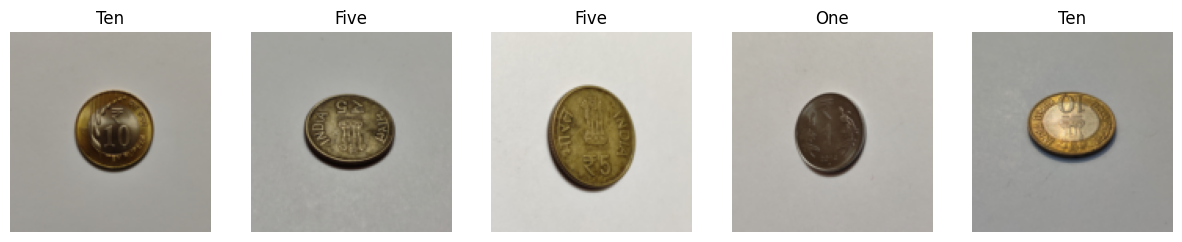

In [59]:
dls.valid.show_batch(max_n=5, nrows=1)

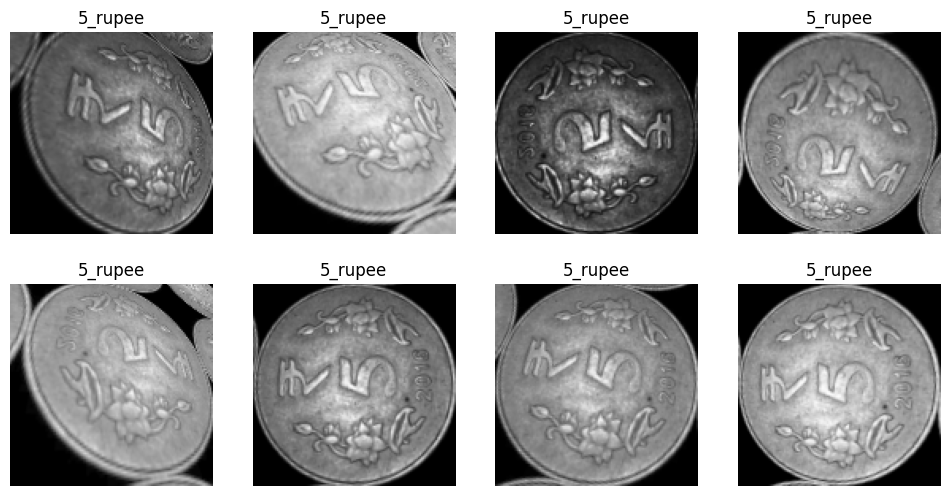

In [16]:
coins = coins.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = coins.dataloaders(images_path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [60]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.896788,0.787199,0.300000,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.885333,0.441279,0.194444,01:07
1,0.623069,0.350031,0.116667,01:06
2,0.457638,0.335363,0.088889,01:09
3,0.351611,0.307559,0.094444,01:05


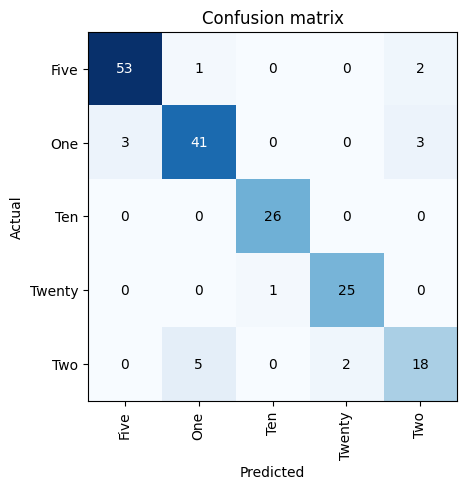

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

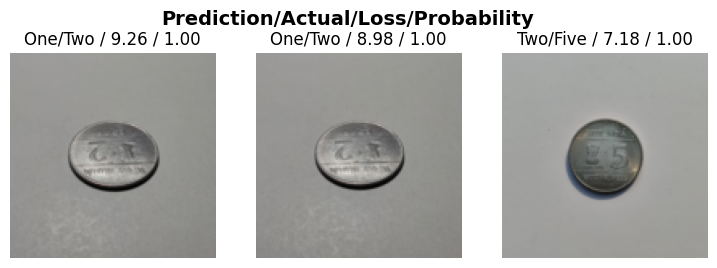

In [62]:
interp.plot_top_losses(3, nrows=1)

In [63]:
learn.export()

In [64]:
learn = load_learner('export.pkl')

In [65]:
labels = learn.dls.vocab
print(labels)

['Five', 'One', 'Ten', 'Twenty', 'Two']
